# Fine-tune MaskFormer for semantic segmentation

In this notebook, we'll show how to fine-tune the model on a semantic segmentation dataset. In semantic segmentation, the goal for the model is to segment general semantic categories in an image, like "building", "people", "sky". No distinction is made between individual instances of a certain category, i.e. we just come up with one mask for the "people" category for instance, not for the individual persons.

Make sure to run this notebook on a GPU.

## Set-up environment

First, we install the necessary libraries. 🤗, what else? Oh yes we'll also use [Albumentations](https://albumentations.ai/), for some data augmentation to make the model more robust. You can of course use any data augmentation library of your choice.

In [ ]:
# import os
# gpu=input("Which gpu number you would like to allocate:")
# os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu)

In [ ]:
!pip install transformers datasets albumentations

In [ ]:
!pip install -q kaggle timm

# load custom data

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images
!unzip -q /content/38cloud-cloud-segmentation-in-satellite-images.zip -d /content/38-cloud-dataset

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()

        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch

    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):

        files = {'red': r_file,
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files

    def __len__(self):

        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))

        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)


    def open_mask(self, idx, add_dims=False):

        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)

        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):

        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)

        return x, y

    def open_as_pil(self, idx):

        arr = 256*self.open_as_array(idx)

        return Image.fromarray(arr.astype(np.uint8), 'RGB')

    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [ ]:
base_path = Path('/content/38-cloud-dataset/38-Cloud_training')
data = CloudDataset(base_path/'train_red',
                    base_path/'train_green',
                    base_path/'train_blue',
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

In [ ]:
x, y = data[1000]
x.shape, y.shape

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(630))
ax[1].imshow(data.open_mask(630))

In [ ]:
data.open_as_pil(8399)

In [ ]:
import torchvision.transforms as transforms

labels_train = []

for img, label in data:
  tensor_to_pil = transforms.ToPILImage()
  image = torch.tensor(label, dtype = torch.float32)

  image = tensor_to_pil(image)

  # Resize the image to the desired height and width (384x384 in this case)
  image = image.resize((384, 384), Image.NEAREST)
  labels_train.append(image)

print(len(labels_train))

In [ ]:
labels_train[:5]

In [ ]:
images_train = []

for i in range(len(data)):
  images_train.append(data.open_as_pil(i))

In [ ]:
images_train[:5]

In [ ]:
data[0][1].shape

In [ ]:
# !pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import Dataset, DatasetDict, Image
import os

# your images can of course have a different extension
# semantic segmentation maps are typically stored in the png format




# image_paths_train = ["/content/img2.png"]# "path/to/image_2.jpg/jpg", ..., "path/to/image_n.jpg/jpg"]
# label_paths_train = ["/content/img2.png",] # "path/to/annotation_2.png", ..., "path/to/annotation_n.png"]

# label_paths_train = os.listdir("/content/38-cloud-dataset/train_gt_png")
# print(sorted(label_paths_train[:]))

# same for validation
# image_paths_validation = [...]
# label_paths_validation = [...]

# def create_dataset(image_paths, label_paths):
#     dataset = Dataset.from_dict({"image": sorted(image_paths),
#                                 "label": sorted(label_paths)})
#     dataset = dataset.cast_column("image", Image())
#     dataset = dataset.cast_column("label", Image())

#     return dataset

def create_dataset(images, labels):
  dataset = Dataset.from_dict({"image": images,
                                "label": labels})
  return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(images_train, labels_train)

print(train_dataset)

# validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    # "validation": validation_dataset,
  }
)

print(dataset, dataset['train'][0])

# step 3: push to hub (assumes you have ran the huggingface-cli login command in a terminal/notebook)
dataset.push_to_hub("38-cloud-train-only-v2")

## Load data

Now let's the dataset from the hub.

"But how can I use my own dataset?" Glad you asked. I wrote a detailed guide for that [here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data).

In [1]:
from datasets import load_dataset

dataset = load_dataset("jaygala223/38-cloud-train-only-v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/jaygala223--38-cloud-train-only-v2-8694e732c8608fcc/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
print(dataset['train'][0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=384x384 at 0x7ED38A7D9360>, 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=384x384 at 0x7ED38A7D9240>}


In [ ]:
# import json
# # simple example
# id2label = {0: 'non-cloud', 1: 'cloud'}
# with open('id2label.json', 'w') as fp:
#     json.dump(id2label, fp)

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("segments/sidewalk-semantic")

Let's take a look at this dataset in more detail. It consists of 1000 examples:

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [ ]:
# dataset

In [3]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [4]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 6720
})

In [5]:
test_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 1680
})

In [ ]:
# from PIL import Image
# for example in train_ds:
#     pil_image = example['label']  # Assuming 'label' contains the PIL image

#     # Convert the PIL image to a NumPy array
#     np_array = np.array(pil_image)

#     # Normalize the values in the NumPy array to be between 0 and 1
#     normalized_array = np_array / 255.0

#     # Convert the normalized NumPy array back to a PIL image
#     example['label'] = Image.fromarray((normalized_array).astype(np.uint8))

# for example in test_ds:
#   np_label = np.array(example['label'])
#   np_label =

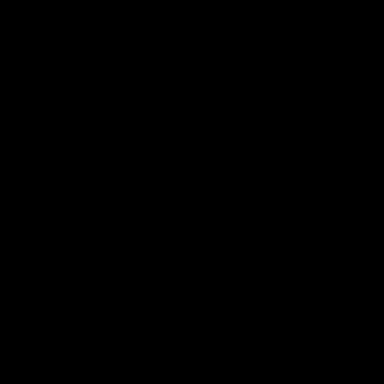

In [6]:
# let's look at one example (images are pretty high resolution)
example = train_ds[1008]
image = example['image']
image

In [7]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [8]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Let's look at the semantic categories in this particular example.

In [9]:
np.unique(segmentation_map)

array([0], dtype=uint8)

In [ ]:
# np.unique(segmentation_map)

Cool, but we want to know the actual class names. For that we need the id2label mapping, which is hosted in a repo on the hub.

In [10]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [ ]:
# from huggingface_hub import hf_hub_download
# import json

# repo_id = f"segments/sidewalk-semantic"
# filename = "id2label.json"
# id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
# id2label = {int(k):v for k,v in id2label.items()}
# print(id2label)

In [11]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['non-cloud']


In [ ]:
# labels = [id2label[label] for label in np.unique(segmentation_map)]
# print(labels)

Let's visualize it:

In [12]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    # return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    #         [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    #         [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    #         [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    #         [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    #         [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    #         [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    #         [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    #         [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    #         [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    #         [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    #         [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    #         [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    #         [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    #         [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    #         [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    #         [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    #         [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    #         [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    #         [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    #         [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    #         [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    #         [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    #         [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    #         [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    #         [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    #         [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    #         [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    #         [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    #         [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    #         [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    #         [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    #         [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    #         [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    #         [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    #         [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    #         [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    #         [102, 255, 0], [92, 0, 255]]

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

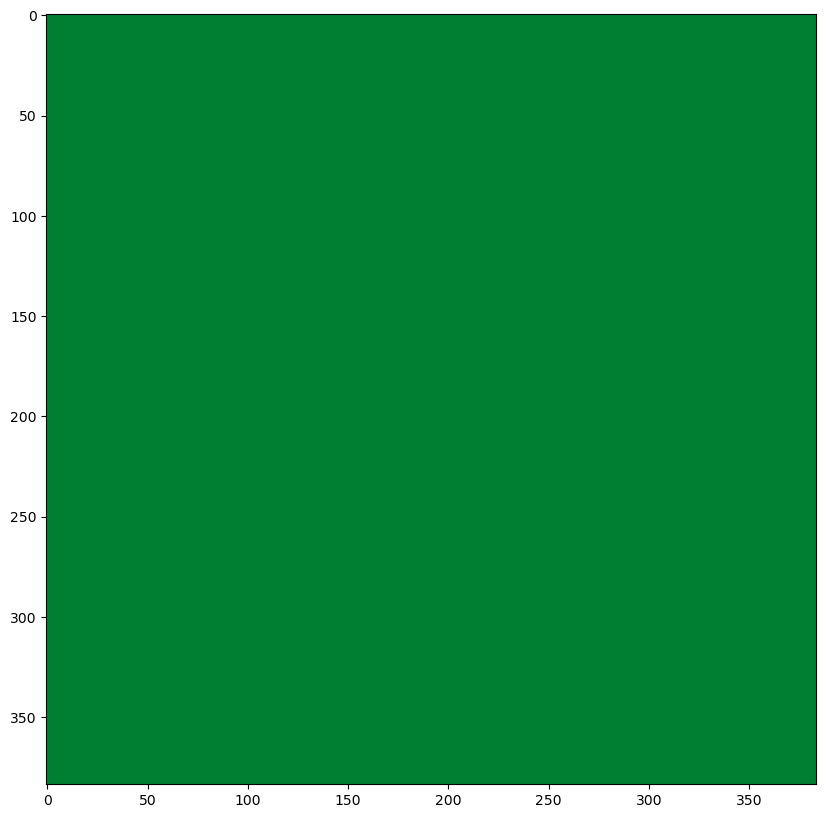

In [13]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [14]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])
        
        # adding one bottom most pixel as 255 since processor/feature_extractor 
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255
        
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [ ]:
# !pip install albumentations opencv-python

In [15]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
#     A.LongestMaxSize(max_size=384),
#     A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
#     A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])
# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# cnt = 0

# for item in train_dataset:
#     label = item[3]
#     uniques = np.unique(label)
#     if sum(uniques) == 0:
#         cnt += 1

# print(cnt)

In [ ]:
# my_array = np.array([
#     [1,2,3],
#     [4,5,6],
#     [7,8,9]
# ])

# print(my_array.shape)

# my_array[-1,-1] = -1

# print(my_array)

In [ ]:
# for item in train_dataset:
#   print(item)

In [16]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [ ]:
# image, segmentation_map, _, _ = train_dataset[0]
# print(image.shape)
# print(segmentation_map.shape)

A great way to check that our data augmentations are working well is by denormalizing the pixel values. So here we perform the inverse operation of Albumentations' normalize method and visualize the image:

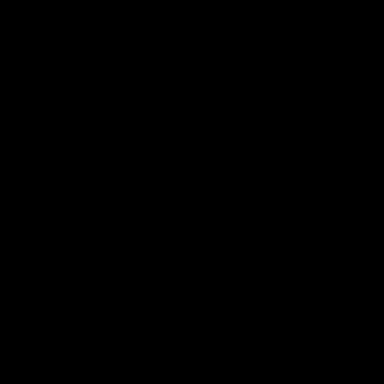

In [17]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
# from PIL import Image

# unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
# Image.fromarray(unnormalized_image)

This looks ok. Let's also verify whether the corresponding ground truth map is still ok.

In [ ]:
segmentation_map.shape

In [ ]:
# segmentation_map.shape

In [18]:
labels = [id2label[label] for label in np.unique(segmentation_map/255.0)]
print(labels)

['non-cloud', 'cloud']


In [ ]:
# labels = [id2label[label] for label in np.unique(segmentation_map)]
# print(labels)

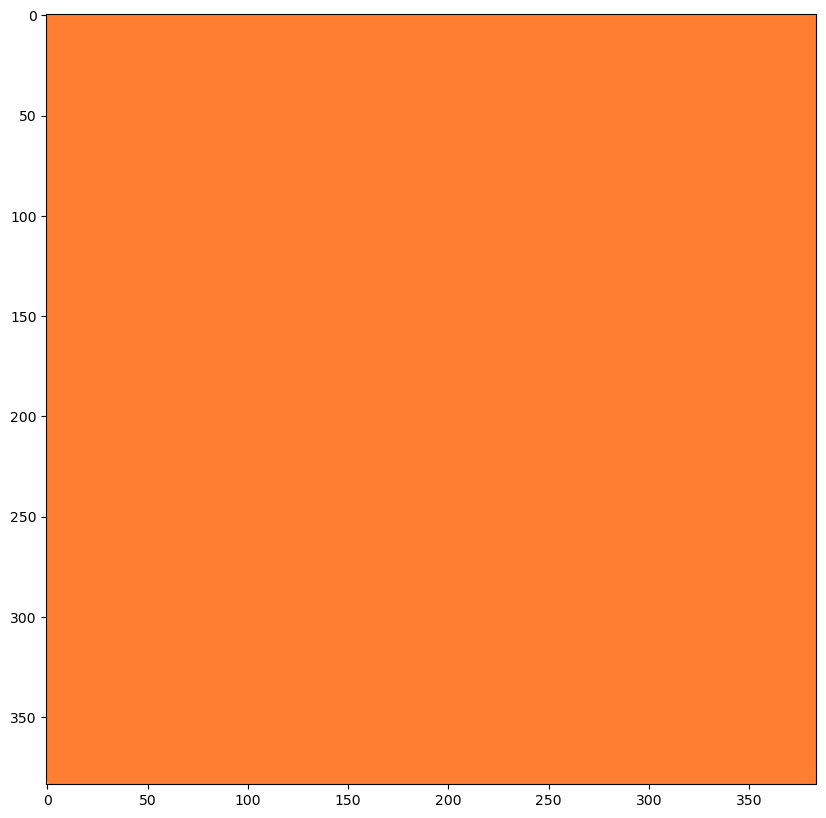

In [19]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
# for label, color in enumerate(palette):
#     color_segmentation_map[segmentation_map == label, :] = color
# # Convert to BGR
# ground_truth_color_seg = color_segmentation_map[..., ::-1]

# img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

Ok great!

## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [20]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = Mask2FormerImageProcessor(ignore_index=0, 
                                        do_reduce_labels=False, 
                                        do_resize=False, 
                                        do_rescale=False, 
                                        do_normalize=True,
                                        size=size)

#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [21]:
preprocessor

Mask2FormerImageProcessor {
  "_max_size": 1333,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 0,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "Mask2FormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 384,
    "shortest_edge": 384
  },
  "size_divisor": 32
}

In [ ]:
# train_dataset[0]

In [22]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

In [24]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 4 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
# for item in train_dataloader:
#     print(item.keys())
#     break

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [25]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([4, 3, 384, 384])
pixel_mask torch.Size([4, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [26]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 384, 384)

Again, let's denormalize an image and see what we got.

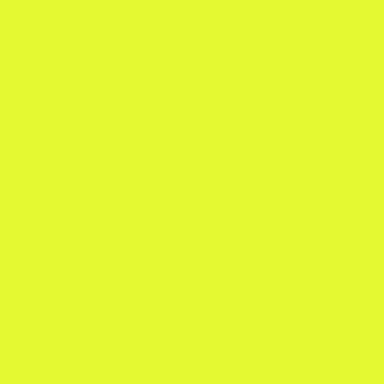

In [29]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [ ]:
# unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
# Image.fromarray(unnormalized_image)

Let's verify the corresponding binary masks + class labels.

In [33]:
# verify class labels
labels = [id2label[label] for label in (batch["class_labels"][0]/255.0).tolist()]
print(labels)

['cloud']


In [ ]:
# # verify class labels
# labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
# print(labels)

In [32]:
# verify mask labels
batch["mask_labels"][0].shape

torch.Size([1, 384, 384])

In [ ]:
# # verify mask labels
# batch["mask_labels"][0].shape

In [30]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: cloud


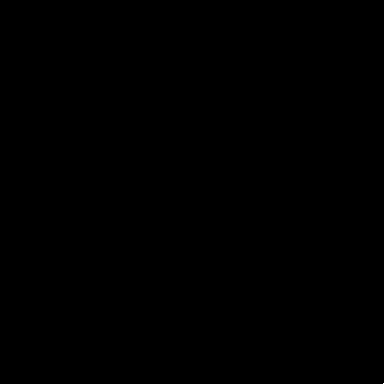

In [34]:
visualize_mask(labels, "cloud")

In [ ]:
# visualize_mask(labels, "flat-road")

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [27]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
                                                            id2label=id2label,
                                                            ignore_mismatched_sizes=True)


# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


See also the warning here: it's telling us that we are

1.   List item
2.   List item

only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Compute initial loss

Another good way to debug neural networks is to verify the initial loss, see if it makes sense.

In [ ]:
# v = batch["class_labels"]

# v = [t / 255.0 for t in v]

In [ ]:
# v

In [ ]:
# v = batch["class_labels"]

# v = [t / 255.0 for t in v]

# new_v = []

# for t in v:
#   new_t = torch.tensor(t, dtype=torch.int64)
#   new_v.append(new_t)

In [ ]:
# [torch.tensor([1.], dtype=torch.uint8)]*2

In [28]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic", 
                                                               size={'longest_edge':384, 'shortest_edge':383}, 
                                                               ignore_index=0)

/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [29]:
feature_extractor

MaskFormerFeatureExtractor {
  "_max_size": 2048,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "ignore_index": 0,
  "image_mean": [
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
  ],
  "image_processor_type": "MaskFormerFeatureExtractor",
  "image_std": [
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
  ],
  "num_labels": 150,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 384,
    "shortest_edge": 383
  },
  "size_divisor": 32
}

In [30]:
device = "cuda"

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)
labels = np.array(labels)
labels = torch.tensor(labels)/255

images.to(device)
labels.to(device)
model.to(device)

inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
# print(inputs)

inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
inputs['class_labels'] = torch.stack(inputs['class_labels'])
inputs['pixel_values'] = inputs['pixel_values'].float()
# print(inputs)
inputs.to(device)

outputs = model(**inputs)

print("done!")

done!


In [ ]:
# [(i//255) for i in batch["class_labels"]]

In [ ]:
# outputs = model(batch["pixel_values"].float(),
#                 class_labels=[(i//255) for i in batch["class_labels"]],
#                 mask_labels=batch["mask_labels"])

In [31]:
outputs.loss

tensor([36.3112], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# outputs.loss

## Train the model

It's time to train the model! We'll use the mIoU metric to track progress.

In [32]:
!pip install -q evaluate

In [33]:
import evaluate

mean_iou = evaluate.load("mean_iou")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")
# clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall", "mean_iou", "recall"])

In [ ]:
# batch["pixel_values"].size(0)

In [ ]:
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=5e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

running_loss = 0.0
num_samples = 0
for epoch in range(30):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)
      model.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#       print(inputs)

      inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
      inputs['class_labels'] = torch.stack(inputs['class_labels'])
      inputs['pixel_values'] = inputs['pixel_values'].float()
      inputs.to(device)

      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 50 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

Epoch: 0


  0%|          | 0/1680 [00:00<?, ?it/s]

Loss: 16.24918556213379
Loss: 7.591471573885749
Loss: 7.032444453475499
Loss: 6.964656081420697
Loss: 6.583544077564828
Loss: 6.3651260094813615
Loss: 6.2638564157327545
Loss: 6.236922338817195
Loss: 6.198635761577292
Loss: 6.070553713785835
Loss: 6.026470329471215
Loss: 6.0053587282201555
Loss: 5.971224181465619
Loss: 5.888044872591572
Loss: 5.8282277677606755
Loss: 5.7827561544514845
Loss: 5.741161393315605
Loss: 5.678629008639433
Loss: 5.637183274069055
Loss: 5.578293408254469
Loss: 5.54637959167793
Loss: 5.521533828480373
Loss: 5.484251960963146
Loss: 5.457453549995721
Loss: 5.452564703534783
Loss: 5.4177478993062875
Loss: 5.404040092738384
Loss: 5.391753125817224
Loss: 5.367371164373973
Loss: 5.330707745951345
Loss: 5.315707053644192
Loss: 5.295661170086039
Loss: 5.259522295906572
Loss: 5.245327128922123
Epoch: 1


  0%|          | 0/1680 [00:00<?, ?it/s]

Loss: 5.222014302586176
Loss: 5.208030709154271


In [55]:
torch.save(model, 'mask2former-model-v2-loss-3.63.pth')

In [58]:
model.eval()
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model.to(device)

    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#     print(inputs)
    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels'])  
    inputs['pixel_values'] = inputs['pixel_values'].float()
    inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      outputs = model(**inputs)

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)
    
#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.cpu()
    for label in labels:
        label.int()
        label.cpu()
        
#     print(predicted_segmentation_maps)
#     print(labels)
    
    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []
    
    for label in labels:
        labels_for_evaluation.append(label.view(-1))
    
    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()
    
    pred_labels_for_evaluation = []
    
    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))
    
    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()
    
    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])
        
    
    mean_iou.add_batch(references=labels_list, predictions=predicted_segmentation_maps)
    precision.add_batch(references=labels_for_evaluation, predictions=pred_labels_for_evaluation)
    recall.add_batch(references=labels_for_evaluation, predictions=pred_labels_for_evaluation)
    f1.add_batch(references=labels_for_evaluation, predictions=pred_labels_for_evaluation)
    accuracy.add_batch(references=labels_for_evaluation, predictions=pred_labels_for_evaluation)
#     clf_metrics.add_batch(references=labels, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
print("mean IoU: ", mean_iou.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])
print("precision", precision.compute()['precision'])
print("accuracy", accuracy.compute()['accuracy'])
print("f1", f1.compute()['f1'])
print("recall", recall.compute()['recall'])

  0%|          | 0/420 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


mean IoU:  1.0
precision 0.25989799519384277
accuracy 0.7442448933919271
f1 0.29082780359497634
recall 0.3301138213117466


In [ ]:
print(labels_for_evaluation)
l = torch.cat(labels_for_evaluation, dim=0)
l.int()

In [ ]:
# import torch
# from tqdm.auto import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# running_loss = 0.0
# num_samples = 0
# for epoch in range(3):
#   print("Epoch:", epoch)
#   model.train()
#   for idx, batch in enumerate(tqdm(train_dataloader)):
#       # Reset the parameter gradients
#       optimizer.zero_grad()

#       # Forward pass
#       outputs = model(
#           pixel_values=batch["pixel_values"].to(device),
#           mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
#           class_labels=[labels.to(device) for labels in batch["class_labels"]],
#       )

#       # Backward propagation
#       loss = outputs.loss
#       loss.backward()

#       batch_size = batch["pixel_values"].size(0)
#       running_loss += loss.item()
#       num_samples += batch_size

#       if idx % 100 == 0:
#         print("Loss:", running_loss/num_samples)

#       # Optimization
#       optimizer.step()

#   model.eval()
#   for idx, batch in enumerate(tqdm(test_dataloader)):
#     if idx > 5:
#       break

#     pixel_values = batch["pixel_values"]

#     # Forward pass
#     with torch.no_grad():
#       outputs = model(pixel_values=pixel_values.to(device))

#     # get original images
#     original_images = batch["original_images"]
#     target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
#     # predict segmentation maps
#     predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
#                                                                                   target_sizes=target_sizes)

#     # get ground truth segmentation maps
#     ground_truth_segmentation_maps = batch["original_segmentation_maps"]

#     metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

#   # NOTE this metric outputs a dict that also includes the mIoU per category as keys
#   # so if you're interested, feel free to print them as well
#   print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

In [ ]:
print("hi")

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [ ]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

In [ ]:
# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [ ]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [ ]:
image = batch["original_images"][0]
Image.fromarray(image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

I didn't do a lot of training (only 2 epochs), and results don't look too bad. I'd suggest checking the paper to find all details regarding training hyperparameters (number of epochs, learning rate, etc.).